In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy as sp
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Basic Parameterized Quantum Circuit

In [5]:
a, b = sp.symbols('a b')

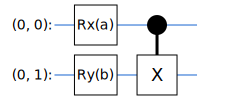

In [3]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create circuit on these qubits using params `a` and `b`
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1)
)

SVGCircuit(circuit)

## Circuit Evaluation

In [7]:
# Calculate a state vector with a=0.5, b=-0.5
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})

output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

### Pauli $\hat Z_0$ Measurement on State Vector

In [8]:
z0 = cirq.Z(q0)

qubit_map = {q0: 0, q1: 1}

z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

### Pauli $\frac{1}{2} \hat Z_0 + \hat X_1$ Measurement on State Vector

In [9]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

-0.04063427448272705

In [12]:
# Rank 1 tensor containing 1 circuit
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [13]:
# Rank 1 tensor containing 2 Pauli operators
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [36]:
# batch of values to sub for `a` and `b` parameters
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

cirq_results = []
cirq_simulator = cirq.Simulator()

for val in batch_vals:
    resolver = cirq.ParamResolver({a: val[0], b: val[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append(
        [z0.expectation_from_wavefunction(final_state, {
            q0: 0,
            q1: 1
        }).real])
    
print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[0.97692353]
 [0.81961894]
 [0.99990046]
 [0.46909943]
 [0.10609788]]
